# 1. Introduction

The following notebook aims to run an analysis and create a model to predict whether a passenger of the *Spacechip Titanic* was transported to an alternate dimension during the spaceship collision. 

The notebook is structured in the following way:
1. Introduction
2. Load libraries and data set
3. Sanity checks
4. Feature engineering
5. Exploratory Data Analysis (EDA)
6. Modeling

The dataset provided (train.csv) consists of the following features:

- **`PassengerId`** - A unique Id for each passenger. Each Id takes the form **`gggg_pp`** where **`gggg`** indicates a group the passenger is travelling with and **`pp`** is their number within the group. People in a group are often family members, but not always.

- **`HomePlanet`** - The planet the passenger departed from, typically their planet of permanent residence.

- **`CryoSleep`** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

- **`Cabin`** - The cabin number where the passenger is staying. Takes the form **`deck/num/side`**, where **`side`** can be either **`P`** for *Port* or **`S`** for *Starboard*.

- **`Destination`** - The planet the passenger will be debarking to.

- **`Age`** - The age of the passenger.

- **`VIP`** - Whether the passenger has paid for special VIP service during the voyage.

- **`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`** - Amount the passenger has billed at each of the *Spaceship Titanic's* many luxury amenities.

- **`Name`** - The first and last names of the passenger.

- **`Transported`** - Whether the passenger was transported to another dimension. This is the target variable, the column you are trying to predict.

The **objective** is to develop an ML model to predict if the passengers provided in the test set (test.csv) were transported or not with an accuracy of, at least, 79%.


# 2. Load libraries and data


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
import warnings
sns.set()
from pandas.api.types import is_numeric_dtype
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate, cross_val_score, ShuffleSplit
from lightgbm import LGBMClassifier
from sklearn import ensemble, discriminant_analysis, linear_model, naive_bayes, neighbors, svm, gaussian_process, tree
from helper_functions import *
import optuna

I will load both the training and testing data sets so all transformations that I apply on the former will be performed in the latter as well.

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (8693, 14)
Test shape: (4277, 13)


In [3]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


The only difference between the two is the target variable, I'll create a dummy variable to identify the training set and fill the target variable with `NaN` values and join the two sets together for easier handling.

In [5]:
train_df['is_train'] = 1
test_df['is_train'] = 0
test_df['Transported'] = np.nan

full_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
full_df.tail()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,is_train
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,0
12966,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,0
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,0
12968,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,0
12969,9277_01,Earth,True,G/1498/S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,NaN,0


In [6]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
 14  is_train      12970 non-null  int64  
dtypes: float64(6), int64(1), object(8)
memory usage: 1.5+ MB


Due to the presence of outliers, `VIP` and `Transported` have been inferred as objects, but they are of type `boolean`. Also, `Age` is an integer, but it's being inferred as float to handle missing values.

# 3. Sanity checks

## 3.1 Duplicate values

In [7]:
full_df.duplicated().sum()

np.int64(0)

There are no duplicates.

## 3.2 Missing values

In [8]:
missing_count = full_df.isnull().sum()
value_count = full_df.isnull().count()
missing_percentage = round(missing_count / value_count * 100, 2)
missing_df = pd.DataFrame({'Missing values': missing_count, 'Percentage': missing_percentage})
missing_df.sort_values(by='Percentage', ascending=False)

,Missing values,Percentage
Transported,4277,32.98
CryoSleep,310,2.39
ShoppingMall,306,2.36
Cabin,299,2.31
VIP,296,2.28
Name,294,2.27
FoodCourt,289,2.23
HomePlanet,288,2.22
Spa,284,2.19
Destination,274,2.11


All null values in the target variable, `Transported` come from the testing set, apart from that, the only feature that does not have missing values is `PassengerId`. Even though missing values represent a small percentage on each of the columns, adding them together could represent a high loss of information if they are droped. 

In [9]:
print(f"Rows in the training set: {train_df.shape[0]}")
print(f"Rows after dropping missing values: {train_df.dropna(axis=0, how='any').shape[0]}")

Rows in the training set: 8693
Rows after dropping missing values: 6606


As it can be seen, if null values are simply dropped we would be losing over 2000 rows of information. Due to that it would be better to impute the values later in the code.

# 4. Feature engineering

I'm going to create some new features out of the ones we have available:

## 4.1 Group features

I'll use the passenger id information to identify passengers travelling alone or in groups and the size of the group:

In [10]:
df = full_df.copy()

df['Group'] = df['PassengerId'].str.split('_').str[0]

group_df = df['Group'].value_counts().reset_index()
group_df.columns = ['Group', 'GroupSize']
group_df['TravelAlone'] = np.where(group_df['GroupSize'] == 1, 1, 0)

df = df.merge(group_df, on='Group', how='left')

## 4.2 Cabin features

The `Cabin` feature is composed of three different components:
- `Deck`
- `Number`
- `Side`

I'll create three fields:

In [11]:
df['CabinDeck'] = df['Cabin'].str.split('/').str[0]
df['CabinNumber'] = df['Cabin'].str.split('/').str[1]
df['CabinSide'] = df['Cabin'].str.split('/').str[2]

df = df.drop(columns='Cabin')

# 5. Exploratory Data Analysis (EDA)

For plotting purposes, I'm making some changes in the data frame.

In [12]:
plotting_df = df.copy()

mapping_dict = {0: 'No', 1: 'Yes'}

cols_to_map = ['TravelAlone', 'Transported', 'VIP']
for col in cols_to_map:
    plotting_df[col] = plotting_df[col].map(mapping_dict)


# Convert GroupSize to ordered category
plotting_df['GroupSize'] = pd.Categorical(
    plotting_df['GroupSize'],
    categories=sorted(plotting_df['GroupSize'].unique()),
    ordered=True
)

In [13]:
num_list = []
cat_list = []

for column in plotting_df.columns:
    if is_numeric_dtype(plotting_df[column]):
        num_list.append(column)
    else:
        cat_list.append(column)

print(f"Numeric columns: {num_list}")
print(f"Categorical columns: {cat_list}")

Numeric columns: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'is_train']
Categorical columns: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Name', 'Transported', 'Group', 'GroupSize', 'TravelAlone', 'CabinDeck', 'CabinNumber', 'CabinSide']


I'll remove some features I don't want to plot:

In [14]:
num_list.remove('is_train')

features_to_remove = ['PassengerId', 'Name', 'Transported', 'Group', 'CabinNumber'] 
for feature in features_to_remove:
    cat_list.remove(feature)

target = 'Transported'

## 5.1 Univariate Analysis

I'm going to explore first the distribution of each variable on its own.

I'll first check the distribution of the target variable:

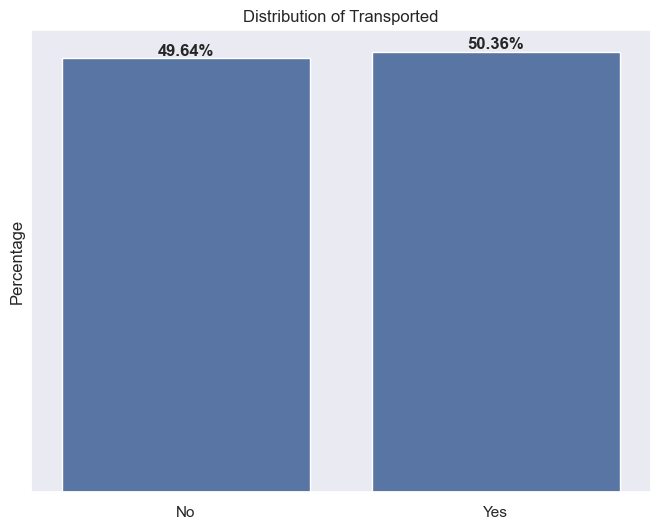

In [15]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=target, data=plotting_df)

total = len(plotting_df[~plotting_df[target].isna()][target])

# Add labels on bars
for p in ax.patches:
    percentage = f"{100 * p.get_height()/total:.2f}%"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Distribution of Transported')
plt.xlabel('')
plt.ylabel('Percentage')
plt.yticks([])

plt.show()

The target variable is evenly distributed across the dataset.

Let's move now to the numerical variables:

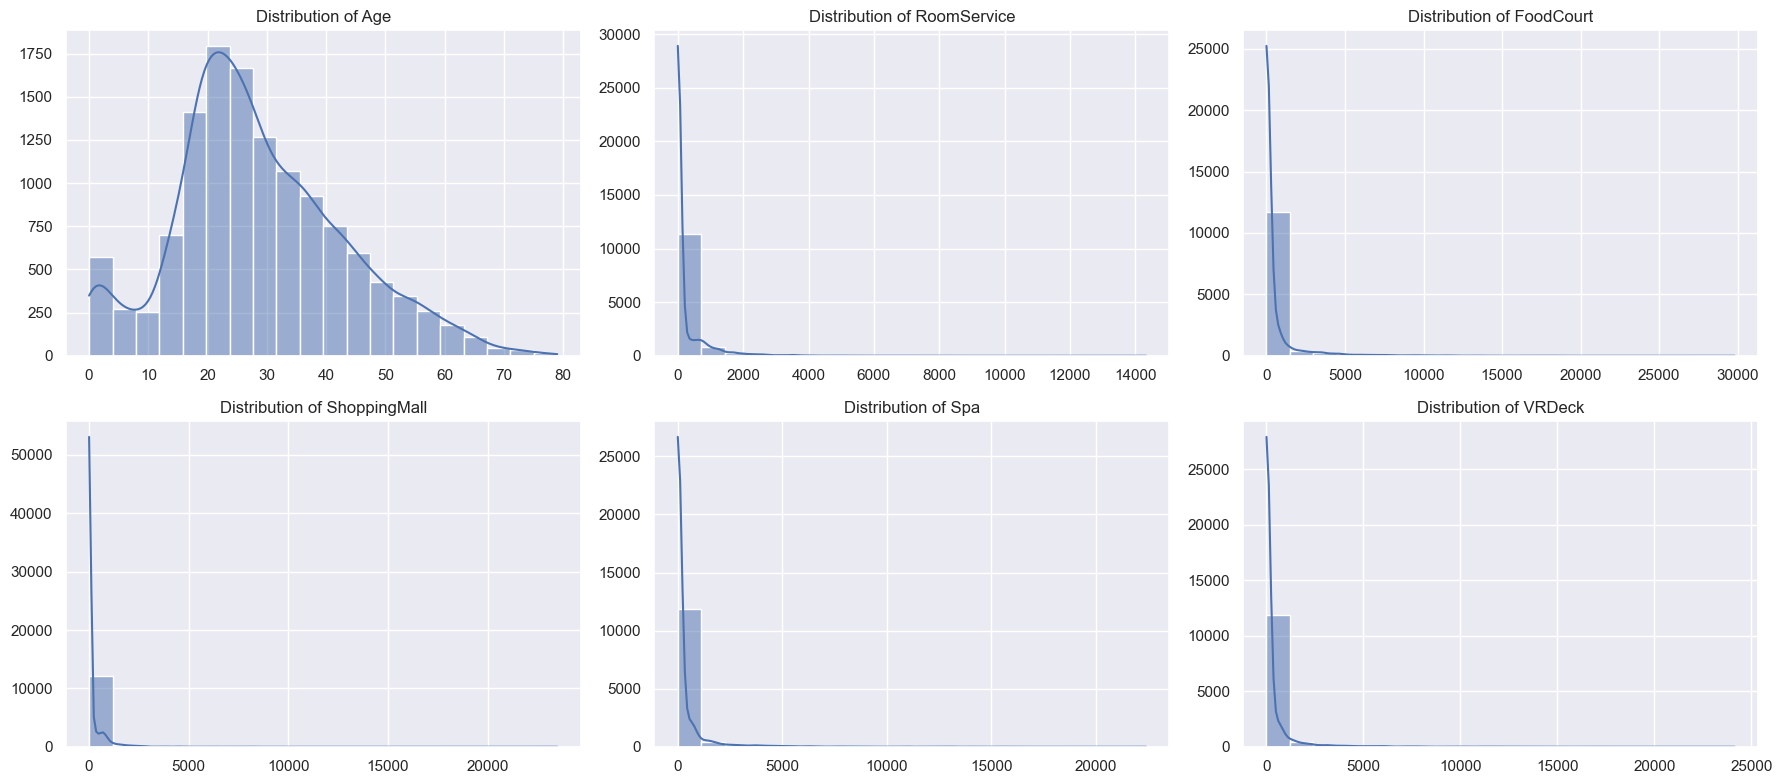

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i, feature in enumerate(num_list):
    sns.histplot(
        plotting_df[feature],
        ax=axes[i],
        kde=True,
        bins=20
    )
    axes[i].set_title(f"Distribution of {feature}")
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

- The `Age` feature is right skewed, showing a concentration of values within the 17-30 range. 
- The remaining numerical features are heavily right-skewed, caused by the presence of outliers. If we want to use them in the models, it would be better to investigate them in more detail to see if they can provide any meaning to the target variable or if they correlate with other variables.

Let's move now to the categorical variables:

In [17]:
# Format the destination for better plotting
destination_mapping = {
    '55 Cancri e': 'Crancri',
    'TRAPPIST-1e': 'TRAPPIST',
    'PSO J318.5-22': 'PSO'
}

plotting_df['Destination'] = plotting_df['Destination'].map(destination_mapping)

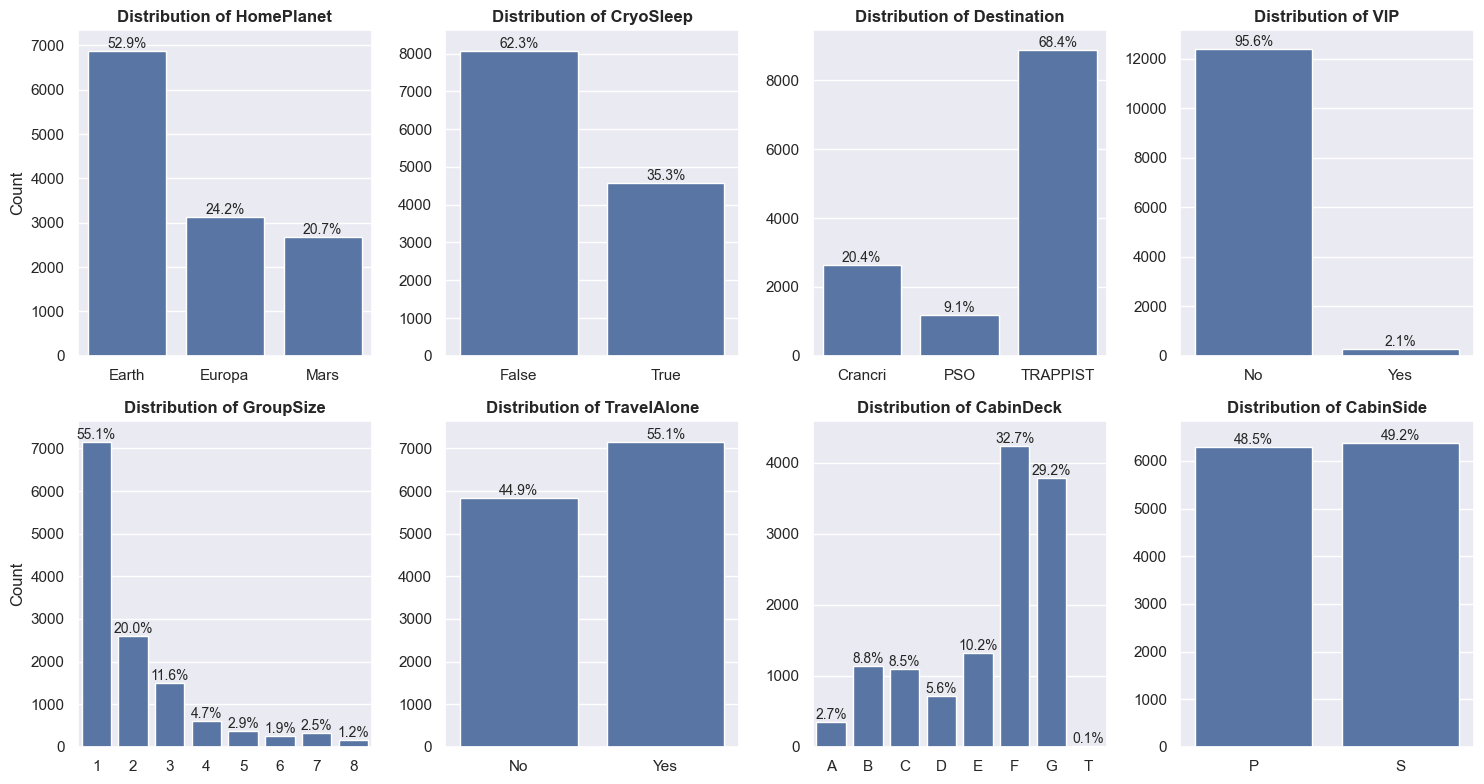

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for i, feature in enumerate(cat_list):
    sns.countplot(
        x=plotting_df[feature],
        ax=axes[i],
        order=sorted(plotting_df[feature].dropna().unique())
    )
    total = len(plotting_df[feature])
    axes[i].set_ylim(0, axes[i].get_ylim()[1] + 0.01 * total)

    for p in axes[i].patches:
        height = p.get_height()
        axes[i].text(
            x=p.get_x() + p.get_width() / 2.,
            y=height,
            s=f"{height / total * 100:.1f}%",
            ha='center',
            va='bottom',
            fontsize=10
        )

    axes[i].set_title(f"Distribution of {feature}", fontweight='bold')
    axes[i].set_xlabel('')
    if i % 4 == 0:
        axes[i].set_ylabel('Count')
    else:
        axes[i].set_ylabel('')
    axes[i].tick_params(axis='x')

plt.tight_layout()
plt.show();

- From the `HomePlanet` distribution it can be seen that **Earth** is the main source of passengers.
- `Destination` hightlights that most passengers will disembark in **TRAPPIST**.
- Only **2.1% were VIP** passengers.
- **55.1% of the passengers travel alone** with the number of passengers in a groups slowly decreasing.
- **More than 60%** of the passengers were given **F** or **G** decks.

## 5.2 Interactions between variables

Let's visualize now how variables interact with each other and with the target variable with the help of the phik correlation matrix. Phik work with numerical and categorical variables and it also captures non-linear relationships.

In [19]:
# I'm removing some columns that I won't be using in the analysis
phik_df = plotting_df.copy()
phik_df.drop(columns=['PassengerId', 'Name', 'Group', 'CabinNumber','is_train'], inplace=True)

interval columns not set, guessing: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


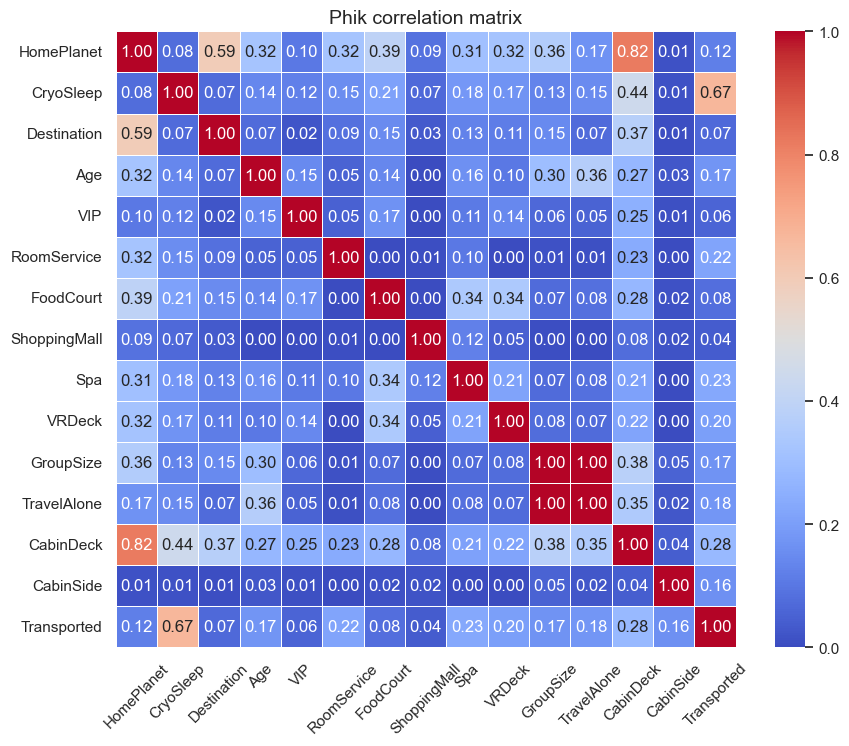

In [20]:
cols_in_order = phik_df.columns.tolist()
cols_in_order.remove('Transported')
cols_in_order.append('Transported')

phik_corr = phik_df[cols_in_order].phik_matrix()
plt.figure(figsize=(10, 8))
sns.heatmap(phik_corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

plt.title('Phik correlation matrix', fontsize=14)
plt.xticks(rotation=45)
plt.show();

- `CryoSleep` is the feature that shows the highest correlation with the target variable and it would be worth exploring it.
- `CabinDeck` comes second, but this relationship could be due to the fact that both `CabinDeck` and `CryoSleep` also show a medium-correlation which could be influencing the relationship with the target.

Other correlations and interactions between variables that stand out are:
- `GroupSize` and `CabinNumber`.
- `HomePlanet` and `CabinDeck`.
- `HomePlanet` and `CabinNumber`.
- `HomePlanet` and `Destination`.

`CabinSide` does not seem to add much information and only shows a weak correlation with the target.

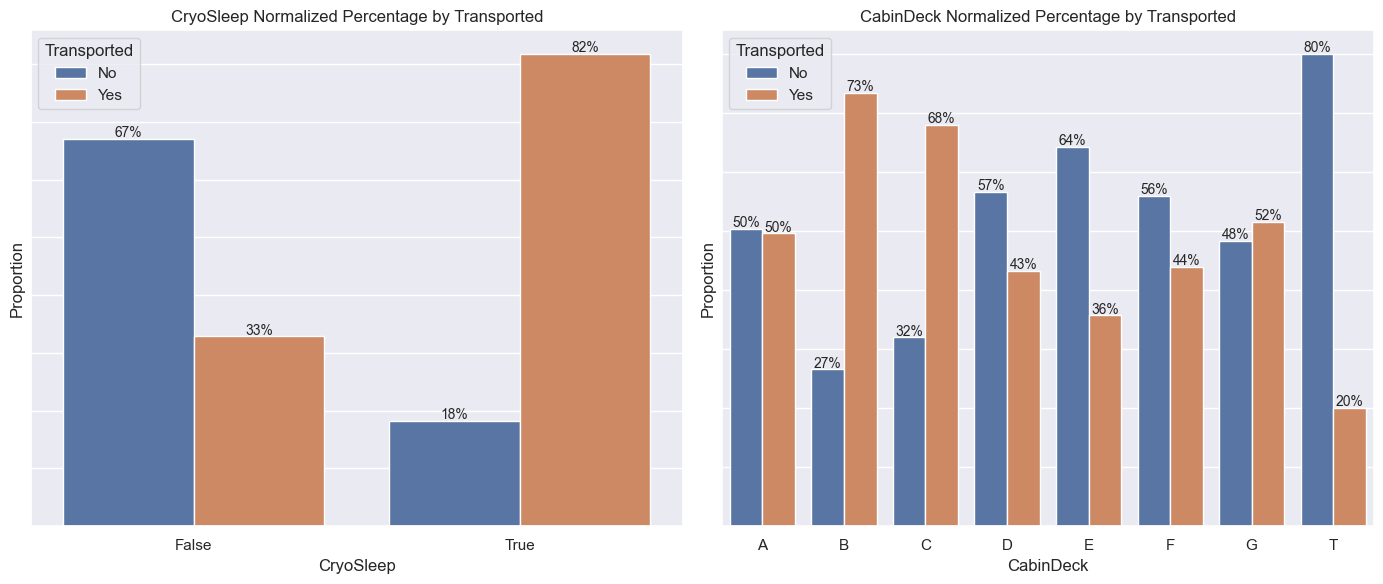

In [21]:
features = ["CryoSleep", "CabinDeck"]

plot_normalized_percentages(plotting_df, features, target, nrows=1, ncols=2, figsize=(14,6))

- From the left plot, we observe a strong relationship. Passengers who chose to be in suspended animation (`CryoSleep = True`) had a significantly higher chance of being transported (82%) compared to those who did not (33%). This suggests that `CryoSleep` may be a **key factor**.

- The right plot highlights the influence of cabin deck location on transportation likelihood. Passengers in **decks B and C** were transported at notably **higher rates (73% and 68%)**, while those in **decks D, E, and F** had relatively **lower transport probabilities**. This suggests that certain decks may have been safer or had a higher chance of successful transportation.
    - One striking observation is **Deck T**, where there is an extreme difference: **80% of passengers were NOT transported**. However, as seen in previous analyses, Deck T had very few passengers, making it difficult to draw definitive conclusions due to limited data.

- Given that **CryoSleep passengers were confined to their cabins**, it raises the question of whether **certain decks had a higher proportion of CryoSleep passengers**, indirectly contributing to their increased transportation rates. If more CryoSleep passengers were placed on specific decks, this could explain why some decks exhibit higher transportation rates than others. Exploring the correlation between deck assignment - CryoSleep - Transported could provide further insights.



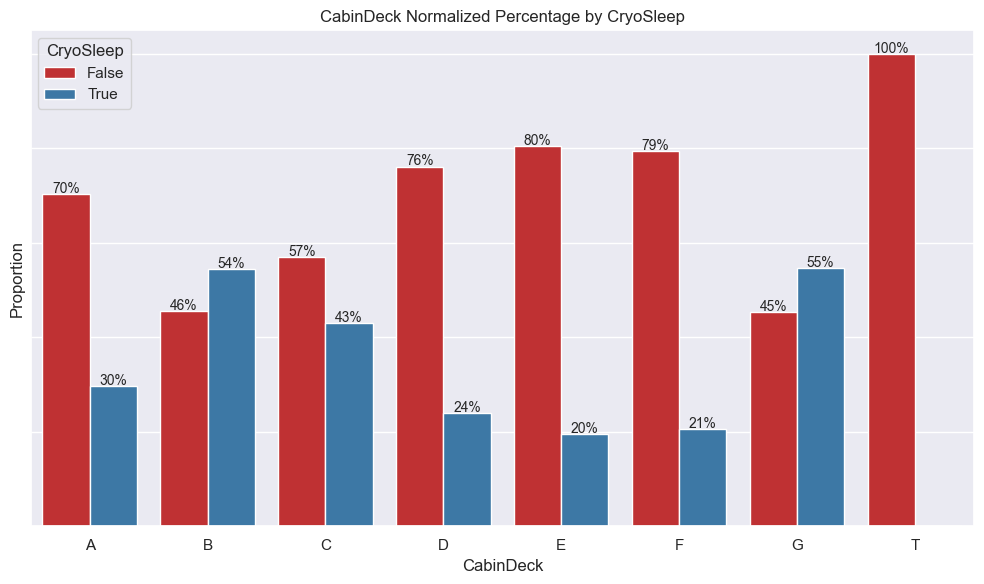

In [22]:
custom_palette = {
    False: "#d7191c",   
    True: "#2c7bb6"  
}
plot_normalized_percentages(plotting_df, ['CabinDeck'], 'CryoSleep', palette=custom_palette)

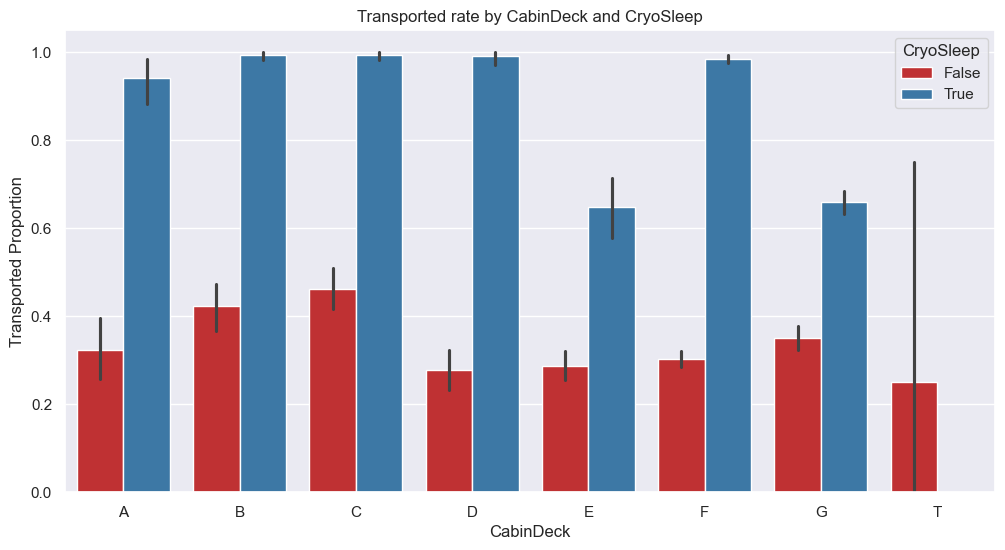

In [23]:
plt.figure(figsize=(12, 6))

sns.barplot(
    data=df,
    x="CabinDeck",
    y="Transported",
    hue="CryoSleep",
    estimator=lambda x: sum(x) / len(x),  # Get percentage transported
    order=sorted(df['CabinDeck'].dropna().unique()),
    palette=custom_palette
)

plt.ylabel("Transported Proportion")
plt.title("Transported rate by CabinDeck and CryoSleep")
plt.show()


Looking at the above two plots it is possible to detect a **strong correlation between CryoSleep status and transport probability**, particularly in decks **A, B, C, D, and F**, where nearly all CryoSleep passengers were transported, even when being in cryo sleep was not the majority of the cases. This suggests that passengers in CryoSleep, particularly in these decks, had conditions favoring transportation. This could be due to the location of those decks in the spaceship, highlihgting that the collision affected more to a specific area of the ship.

This analysis reinforces that both `CryoSleep` and `CabinDeck` played a crucial role in transportation, with `CryoSleep` having a consistently strong positive impact on transportation outcomes.

I have extended the EDA in a second notebook to find out more about the correlations between variables and how to come up with rules to impute the missing values in the current dataset using the information we have at hand. I have separated that in order to make this analysis more digestible to the reader. I'll summarize my findings here but I encourage to take a look at it to follow my thinking process.

In that notebook (`Feature correlation exploration.ipynb`) I have focused on exploring the correlation between independent features at first and investigate then the outliers on the numeric columns. Looking at the **correlation between features** I have come up with the following set of rules to impute missing values:

**HomePlanet**

The function `impute_homeplanet_nulls` imputes null values following these steps:
- Create a dummy variable indicating if the planet was missing.
- If a passenger travels in a group, it uses the information from the group (if available), to impute this value, as it has been observed that there aren't passengers in the same group coming from different home planets.
- In case the information from the group is not available, I'll use the most frequent value of the `CabinDeck` to impute the `HomePlanet`.
- If that record has also missing information for the `CabinDeck`, the function uses the mode by `Destination`.
- If the value is still missing, it will be imputed with the overall mode.


**CryoSleep**

`impute_cryosleep_nulls` follows these steps:
- Creates a new dummy column flagging missing values in this column.
- Then, it checks if the passenger has spent any money on the amenities (this couldn't happen if the passenger was suspended), if it finds any quantity greater than 0, the value will be imputed as `False`.
- If no information is available or all quantities are 0, the missing value will be imputed using the mode per cabin deck.
- Lastly, in case cabin deck is also missing, the imputed value will be the overall mode.

**Cabin**

For imputing cabin features I'm following this approach:
- First, create a dummy variable identifying missing values.
- Then, check if there are other people travelling in the same group and use their values to impute missing values here (this may not be entirely accurate).
- When that information is not available:
    - `CabinDeck` will be imputed using the mode for each `HomePlanet`, as these two variables has shown a strong correlation.
    - `CabinNumber` will be grouped into 5 different groups in a new feature `CabinNoGroup`:
        - Group 0: Cabins from 0 to 299.
        - Group 1: Cabins from 300 to 599.
        - Group 2: Cabins from 600 to 1179.
        - Group 3: Cabins from 1180 to 1699.
        - Group 4: Cabins 1700 and over. 
        - Whenever `CabinNumber` is missing I will assign the groups randomly following the same distribution that I've seen in the original dataset. 
    - `CabinSide` will be picked randomly, as this feature is evenly distributed.


**Destination**

To impute destination nulls, the steps are the following:
- Create a dummy variable flagging missing values.
- Check if there are other passengers in the same group. If so, use their destination, as it has been observed that it is uncommon for people within the same group to travel to different destinations.
- Whenever the previous step is not available, calculate the mode using the home planet.
- Lastly, use the overall mode to impute missing values.


**VIP**

In the data exploration phase, `VIP` did not show any special correlation with other features, so for this feature I'll just use the mode using the simple imputer.


**Age**

As with `VIP`, the `Age` column does not exhibit any strong correlation with other feature that we could use for imputation. In this case I am creating a dummy feature flaggin missing values, then I am imputing missing values with the median and then binning the ages into 4 groups:
- Group 0 will gather babies aged 0, as this group was highly affected by the transportation.
- Group 1 will contain young people aged between 1 and 17 (both included), as this group had a higher likelihood to be trasnported as well but not as high as the previous group.
- Group 2 will contain young adults, aged between 18 and 39 years, since the trend changes at this point.
- Group 4 will contain adults aged 40+. 

![Age binned by target](age_binned_by_transported.png)


**Amenities**

For the amenities with null values, I'm first checking the value of `CryoSleep` as passengers in cryo sleep could not spend any money. If the passenger was in this state, all missing values will be imputed as 0s, else I'm using the median.


Another interesting finding was that, even though from the Phik correlation matrix it would seem that `CabinSide` has no impact on the target variable, its exploration with the `CabinDeck` shows that it can add some information. If we look at cabins **A** and **G**, the distribution of transported changes depending on the side:

![Distribution of Transported by Deck and Side](Distribution_of_target_by_deck_and_side.png)


**Outlier investigation**

Lastly, I investigated the outliers present in the numerical features (excluding age). This investigation led me to think that, instead of dropping outliers or performing any Box-Cox or log transformation, it makes more sense in this specific case to tag passengers that spent **any** money in any of the amenities rather than leaving the numerical values. Targeting outliers in each amenity independently showed a distribution with respect of the target variable of around 70%-30% (non transported - transported), similar to what we can see for people who spent money in any amenity, as can be seen in the following chart:

![Comparison across spending status](comparison_cs_non_spenders.png)



Following all that, I'll perform the mentioned transformations in the data:

In [24]:
imputed_df = (
    df.pipe(impute_homeplanet_nulls)
      .pipe(impute_cryosleep_nulls)
      .pipe(impute_cabin_nulls)
      .pipe(impute_destination_nulls)
      .pipe(impute_age_nulls)
)

amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for amenity in amenities:
    imputed_df = impute_amenities_nulls(imputed_df, amenity)

We should only have missing values in the `Name` (won't be used) field and `VIP` (which will be imputed using the most frequent value by the simple imputer), since the one in `Transported` come from the test set:

In [25]:
imputed_df.isnull().sum()

PassengerId              0
HomePlanet               0
CryoSleep                0
Destination              0
VIP                    296
RoomService              0
FoodCourt                0
ShoppingMall             0
Spa                      0
VRDeck                   0
Name                   294
Transported           4277
is_train                 0
Group                    0
GroupSize                0
TravelAlone              0
CabinDeck                0
CabinSide                0
HomePlanetMissing        0
CryoSleepMissing         0
CabinMissing             0
CabinNoGroup             0
DestinationMissing       0
AgeMissing               0
AgeGroup                 0
dtype: int64

As mentioned, instead of removing outliers in the numerical variables, I'm going to create a new dummy feature that indicates if the passenger spent any money on any of the amenities or not.

In [26]:
imputed_df['SpenderStatus'] = (imputed_df[amenities].gt(0)).any(axis=1).astype(int)

In [27]:
imputed_df['VIP'] = imputed_df['VIP'].astype(float)
imputed_df['CryoSleep'] = imputed_df['CryoSleep'].astype(int)
imputed_df['AgeGroup'] = imputed_df['AgeGroup'].astype(int)
imputed_df['GroupSize'] = imputed_df['GroupSize'].astype(int)

# 6. Modeling

In this part I'll create different models and compare them to se which one is the best performing model. Also I'll build an ensemble of the best performing models to see if that helps improving the accuracy.

In [ ]:
train_processed_df = imputed_df[imputed_df['is_train'] == 1].drop(columns='is_train')
test_processed_df = imputed_df[imputed_df['is_train'] == 0].drop(columns=['is_train', 'Transported']).reset_index(drop=True)

In [30]:
cols_to_exclude = ['PassengerId', 'Name', 'CabinNumber', 'Transported', 'Group']
predictors = [col for col in train_processed_df.columns if col not in cols_to_exclude]
X = train_processed_df[predictors]
y = train_processed_df['Transported'].astype(int)

In [ ]:
numerical_features = amenities
categorical_features = [col for col in X.columns if col not in amenities]

print(f"Categorical features: \n{categorical_features}\n")
print(f"Numerical features: \n{numerical_features}")

Categorical features: 
['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'GroupSize', 'TravelAlone', 'CabinDeck', 'CabinSide', 'HomePlanetMissing', 'CryoSleepMissing', 'CabinMissing', 'CabinNoGroup', 'DestinationMissing', 'AgeMissing', 'AgeGroup', 'SpenderStatus']

Numerical features: 
['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


In [33]:
num_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

cat_pipeline_lm = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ]
)

cat_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

## 6.1. Model comparison

In [ ]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    #lgbm
    LGBMClassifier(verbose=-1)    
    ]

cv_split = ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

row_index = 0
for alg in MLA:

    # Select the appropriate categorical pipeline since some models benefit 
    # from dropping one of the encoded features to avoid correlations
    if isinstance(alg, (
        linear_model.LogisticRegressionCV, 
        linear_model.RidgeClassifierCV, 
        linear_model.SGDClassifier, 
        linear_model.Perceptron,
        discriminant_analysis.LinearDiscriminantAnalysis, 
        discriminant_analysis.QuadraticDiscriminantAnalysis
    )):
        selected_cat_pipeline = cat_pipeline_lm
    else:
        selected_cat_pipeline = cat_pipeline

    preprocessor = ColumnTransformer(
        transformers = [
            ('num', num_pipeline, numerical_features),
            ('cat', selected_cat_pipeline, categorical_features)
        ],
        remainder='passthrough'
    )

    full_pipeline = Pipeline(
        steps = [
            ('preprocessor', preprocessor),
            ('model', alg)
        ]
    )
    
    
    
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    
    cv_results = cross_validate(full_pipeline, X, y, cv=cv_split, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   
    
    row_index+=1


MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
19,LGBMClassifier,"{'boosting_type': 'gbdt', 'class_weight': None...",0.884679,0.803029,0.020436,0.704889
14,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.81745,0.800192,0.019511,1.49902
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.825388,0.79839,0.017782,0.453869
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.878734,0.794018,0.021445,4.113365
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.799732,0.793021,0.014236,0.099997
16,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': 'auto...",0.798236,0.792178,0.017116,0.02411
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.956836,0.792025,0.024586,0.245519
9,SGDClassifier,"{'alpha': 0.0001, 'average': False, 'class_wei...",0.79534,0.791948,0.02307,0.025383
15,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.797507,0.791028,0.024768,1.899906
0,AdaBoostClassifier,"{'algorithm': 'deprecated', 'estimator': None,...",0.791314,0.783321,0.027092,0.1264


## 6.2 Ensembling 

Let's take the top four performing models and build an ensemble to see if we can improve the prediction:

In [35]:
best_models = [
    ('lgb', LGBMClassifier(verbose=-1)),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('svc', svm.SVC(probability=True)),
    ('gpc', gaussian_process.GaussianProcessClassifier()),
]

preprocessor = ColumnTransformer(
        transformers = [
            ('num', num_pipeline, numerical_features),
            ('cat', cat_pipeline, categorical_features)
        ],
        remainder='passthrough'
    )

# Hard vote
vote_hard = ensemble.VotingClassifier(estimators=best_models, voting='hard')
vote_hard_pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('model', vote_hard)  
])
vote_hard_cv = cross_validate(vote_hard_pipeline, X, y, cv=cv_split, return_train_score=True)
print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)

# Soft vote
vote_soft = ensemble.VotingClassifier(estimators=best_models, voting='soft')
vote_soft_pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('model', vote_soft)  
])
vote_soft_cv = cross_validate(vote_soft_pipeline, X, y, cv=cv_split, return_train_score=True)
print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))


Hard Voting Training w/bin score mean: 85.21
Hard Voting Test w/bin score mean: 80.23
Hard Voting Test w/bin score 3*std: +/- 1.83
----------
Soft Voting Training w/bin score mean: 85.09
Soft Voting Test w/bin score mean: 80.23
Soft Voting Test w/bin score 3*std: +/- 1.67


From the results we can see that none of the voting ensembles has achieved any improvement of the best performing model. Now, the models used here are the base models but I would like to see if this can be further improved using hyperparameter tuning for each of them and then, run a soft voting algorithm again.

## 6.3 Hyperparameter tunning

I'll use optuna to automate the tuning of the hyperparameters for each of the classifiers used in the previous section:

In [ ]:
def objective(trial, model_name):
    if model_name == "LGBMClassifier":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'num_leaves': trial.suggest_int('num_leaves', 10, 50),
            'max_depth': trial.suggest_int('max_depth', -1, 20),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
        }
        model = LGBMClassifier(**params, random_state=42)

    elif model_name == "GradientBoostingClassifier":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
        }
        model = ensemble.GradientBoostingClassifier(**params, random_state=42)

    elif model_name == "SVC":
        params = {
            'C': trial.suggest_float('C', 0.1, 10.0, log=True),
            'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
            'degree': trial.suggest_int('degree', 2, 5) if 'poly' in trial.params.get('kernel', 'rbf') else 3,
            'gamma': trial.suggest_categorical('gamma', ['scale', 'auto'])
        }
        model = svm.SVC(**params, probability=True, random_state=42)

    elif model_name == "GaussianProcessClassifier":
        params = {
            'max_iter_predict': trial.suggest_int('max_iter_predict', 50, 500, step=50),
            'n_restarts_optimizer': trial.suggest_int('n_restarts_optimizer', 0, 10)
        }
        model = gaussian_process.GaussianProcessClassifier(**params, random_state=42)

    else:
        raise ValueError("Unsupported model name")


    full_pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ]
    )

    score = cross_val_score(full_pipeline, X, y, cv=cv_split, scoring='accuracy').mean()
    
    return score

In [ ]:
models_to_optimize = ["LGBMClassifier", "GradientBoostingClassifier", "SVC", "GaussianProcessClassifier"]

best_params_dict = {}

# Run Optuna optimization for each model
for model_name in models_to_optimize:
    print(f"🔍 Running Optuna for {model_name}...")
    
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, model_name), n_trials=10)

    best_params_dict[model_name] = study.best_params
    print(f"✅ Best Parameters for {model_name}: {study.best_params}")
    print(f"🏆 Best Score: {study.best_value:.4f}\n")

# Store all optimized hyperparameters
print("🎯 Final Optimized Parameters:")
for model, params in best_params_dict.items():
    print(f"{model}: {params}")

[I 2025-03-14 16:49:30,185] A new study created in memory with name: no-name-587a8700-92d4-4051-b75c-3430a6b2aa9b


🔍 Running Optuna for LGBMClassifier...


[I 2025-03-14 16:51:14,657] Trial 0 finished with value: 0.7846625766871166 and parameters: {'n_estimators': 1000, 'learning_rate': 0.18632819285834118, 'num_leaves': 47, 'max_depth': 16, 'min_child_samples': 9, 'subsample': 0.6793154561683092, 'colsample_bytree': 0.7792333978538967}. Best is trial 0 with value: 0.7846625766871166.
[I 2025-03-14 16:52:03,580] Trial 1 finished with value: 0.7909892638036811 and parameters: {'n_estimators': 800, 'learning_rate': 0.06983217156276401, 'num_leaves': 36, 'max_depth': 10, 'min_child_samples': 42, 'subsample': 0.7711003564575865, 'colsample_bytree': 0.9557224333025371}. Best is trial 1 with value: 0.7909892638036811.
[I 2025-03-14 16:52:08,912] Trial 2 finished with value: 0.8042944785276074 and parameters: {'n_estimators': 200, 'learning_rate': 0.07138579666969383, 'num_leaves': 11, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.8122516792140727, 'colsample_bytree': 0.8074897827347767}. Best is trial 2 with value: 0.8042944785276074.

✅ Best Parameters for LGBMClassifier: {'n_estimators': 200, 'learning_rate': 0.07138579666969383, 'num_leaves': 11, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.8122516792140727, 'colsample_bytree': 0.8074897827347767}
🏆 Best Score: 0.8043

🔍 Running Optuna for GradientBoostingClassifier...


[I 2025-03-14 16:56:26,471] Trial 0 finished with value: 0.7881134969325154 and parameters: {'n_estimators': 300, 'learning_rate': 0.08504209807855599, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7881134969325154.
[I 2025-03-14 16:57:00,908] Trial 1 finished with value: 0.7945168711656441 and parameters: {'n_estimators': 600, 'learning_rate': 0.16572949993823283, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.7945168711656441.
[I 2025-03-14 16:58:13,056] Trial 2 finished with value: 0.7823236196319019 and parameters: {'n_estimators': 600, 'learning_rate': 0.17452921583638448, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.7945168711656441.
[I 2025-03-14 16:59:24,316] Trial 3 finished with value: 0.7876533742331289 and parameters: {'n_estimators': 500, 'learning_rate': 0.1158650810312789, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_

✅ Best Parameters for GradientBoostingClassifier: {'n_estimators': 400, 'learning_rate': 0.048919255959431765, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5}
🏆 Best Score: 0.8012

🔍 Running Optuna for SVC...


[I 2025-03-14 17:04:26,835] Trial 0 finished with value: 0.7897239263803681 and parameters: {'C': 0.147827048104484, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.7897239263803681.
[I 2025-03-14 17:04:44,872] Trial 1 finished with value: 0.8001917177914111 and parameters: {'C': 1.134505599985444, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 1 with value: 0.8001917177914111.
[I 2025-03-14 17:04:55,290] Trial 2 finished with value: 0.7998466257668712 and parameters: {'C': 9.5752861781286, 'kernel': 'poly', 'degree': 2, 'gamma': 'auto'}. Best is trial 1 with value: 0.8001917177914111.
[I 2025-03-14 17:05:13,426] Trial 3 finished with value: 0.8016104294478528 and parameters: {'C': 4.871912594645704, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 3 with value: 0.8016104294478528.
[I 2025-03-14 17:05:24,617] Trial 4 finished with value: 0.791180981595092 and parameters: {'C': 0.35583255115165124, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 3 with value

✅ Best Parameters for SVC: {'C': 4.871912594645704, 'kernel': 'rbf', 'gamma': 'scale'}
🏆 Best Score: 0.8016

🔍 Running Optuna for GaussianProcessClassifier...


[I 2025-03-14 17:07:10,534] Trial 0 finished with value: 0.7940184049079754 and parameters: {'max_iter_predict': 250, 'n_restarts_optimizer': 6}. Best is trial 0 with value: 0.7940184049079754.
[I 2025-03-14 17:07:54,191] Trial 1 finished with value: 0.7940184049079754 and parameters: {'max_iter_predict': 250, 'n_restarts_optimizer': 3}. Best is trial 0 with value: 0.7940184049079754.
[I 2025-03-14 17:24:10,236] Trial 2 finished with value: 0.7940184049079754 and parameters: {'max_iter_predict': 200, 'n_restarts_optimizer': 1}. Best is trial 0 with value: 0.7940184049079754.
[I 2025-03-14 17:40:34,199] Trial 3 finished with value: 0.7940184049079754 and parameters: {'max_iter_predict': 300, 'n_restarts_optimizer': 8}. Best is trial 0 with value: 0.7940184049079754.
[I 2025-03-14 17:56:59,735] Trial 4 finished with value: 0.7940184049079754 and parameters: {'max_iter_predict': 450, 'n_restarts_optimizer': 8}. Best is trial 0 with value: 0.7940184049079754.
[I 2025-03-14 18:13:37,733] Tr

✅ Best Parameters for GaussianProcessClassifier: {'max_iter_predict': 250, 'n_restarts_optimizer': 6}
🏆 Best Score: 0.7940

🎯 Final Optimized Parameters:
LGBMClassifier: {'n_estimators': 200, 'learning_rate': 0.07138579666969383, 'num_leaves': 11, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.8122516792140727, 'colsample_bytree': 0.8074897827347767}
GradientBoostingClassifier: {'n_estimators': 400, 'learning_rate': 0.048919255959431765, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5}
SVC: {'C': 4.871912594645704, 'kernel': 'rbf', 'gamma': 'scale'}
GaussianProcessClassifier: {'max_iter_predict': 250, 'n_restarts_optimizer': 6}


After tunning I'll get the best parameters and run a soft voting algorithm to see if that improves the accuracy of LGBM on its own.

In [ ]:
best_params_lgbm = best_params_dict["LGBMClassifier"]
best_params_gbc = best_params_dict["GradientBoostingClassifier"]
best_params_svc = best_params_dict["SVC"]
best_params_gpc = best_params_dict["GaussianProcessClassifier"]


lgbm_model = LGBMClassifier(**best_params_lgbm, random_state=42)
gbc_model = ensemble.GradientBoostingClassifier(**best_params_gbc, random_state=42)
svc_model = svm.SVC(**best_params_svc, probability=True, random_state=42)
gpc_model = gaussian_process.GaussianProcessClassifier(**best_params_gpc, random_state=42)

voting_soft = ensemble.VotingClassifier(
    estimators=[
        ('lgb', lgbm_model),
        ('gbc', gbc_model),
        ('svc', svc_model),
        ('gpc', gpc_model)
    ],
    voting='soft'  
)

vote_soft_pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('model', vote_soft)  
])
vote_soft_cv = cross_validate(vote_soft_pipeline, X, y, cv=cv_split, return_train_score=True)
print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))

Soft Voting Training w/bin score mean: 85.10
Soft Voting Test w/bin score mean: 80.24
Soft Voting Test w/bin score 3*std: +/- 1.71


Soft voting did not improved the score of just running LGBM, so I'll stick with that model with its best parameters and calculate the prediction for the test set.

## 6.4 Prediction

In [40]:
best_params = study.best_params
final_classifier = LGBMClassifier(**best_params, random_state=42)

full_pipeline = Pipeline(
        steps = [
            ('preprocessor', preprocessor),
            ('model', final_classifier)
        ]
    )

full_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['RoomService', 'FoodCourt',
                                                   'ShoppingMall', 'Spa',
                                                   'VRDeck']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP',
                                                   'GroupSize', 'TravelAlone',
                                                   'CabinDeck', 'CabinSide',
                                                   'HomePlanetMissing',
                                                   'CryoSleepMissing',
                                                   'CabinMissing',
                                                   'CabinNoGroup',
                                                   'DestinationMissing',
                                                   'AgeMissing', 'AgeGroup',
                                                   'SpenderStatus'])])),
                ('model',
                 LGBMClassifier(max_iter_predict=250, n_restarts_optimizer=6,
                                random_state=42))])

In [ ]:
cv_results = cross_validate(full_pipeline, X, y, cv=cv_split, return_train_score=True)
mean_train_acc = cv_results['train_score'].mean()
mean_test_acc = cv_results['test_score'].mean()   
test_3_std = cv_results['test_score'].std()*3

print(f"Mean accuracy on train: {mean_train_acc*100:.2f}\n",
      f"Mean accuracy on test: {mean_test_acc*100:.2f}\n",
      f"Test accucary score 3*std: {test_3_std*100:.2f}"
      )

Mean accuracy on train: 88.47
 Mean accuracy on test: 80.30
 Test accucary score 3*std: 2.04


In [41]:
X_test = test_processed_df[predictors]

y_pred = full_pipeline.predict(X_test)

In [ ]:
y_pred_series = pd.Series(y_pred.astype(bool), index=test_processed_df.index, name="Transported")

submission_df = pd.concat([test_processed_df['PassengerId'], y_pred_series], axis=1)
submission_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [43]:
submission_df.to_csv('submission1.csv', index=False)